# Training

This Google Colab notebook trains a model for each subject.

To run successfully you must have the preprocessed Swell dataset in the `dataset` folder as a `pkl` file named `dataset_swell_processed.pkl`.
This file can be recreated by running the `preprocessing.ipynb` notebook.
By default the `dataset` folder should be in your Google Drive under a top-level folder named `STREDWES-SWELL`. You can change the default by changing the variable `SWELL_KW_DIR` below. If you did not run the preprocessing pipeline before a copy of this preprocessed dataset is already available from the GitHub repository in the `dataset` folder of the repository and it will be used instead.

To speed-up training, make sure that you select a Google Colab runtime with a GPU.

This notebook store the results in a `results` subfolder of top-level Google Drive folder whose name is in the variable `SWELL_KW_DIR`.

In [21]:
!git clone https://github.com/TheCoolCodeName/STREDWES-SWELL
%cd STREDWES-SWELL
!pip install -r requirements.txt

Cloning into 'STREDWES-SWELL'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 74 (delta 33), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (74/74), 24.44 KiB | 3.05 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/content/STREDWES-SWELL/STREDWES-SWELL


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORTANT** Change the following variable `SWELL_KW_DIR` to match the name of the folder under your Google Drive root that will store the final results in the `results` subfolder.

In [23]:
SWELL_KW_DIR='STREDWES-SWELL'

In [24]:
# Check that the code has been cloned
import os

def check_environment_cloned(env_directory):
    return os.path.exists(env_directory)

work_dir = "/content/STREDWES-SWELL"

# Replace 'your_env_directory' with the path to your environment directory
env_cloned = check_environment_cloned(work_dir)
print(f'Environment cloned: {env_cloned}')

Environment cloned: True


In [25]:
# Setting working dir & data folders paths
os.chdir(work_dir)
print('Work_dir:',work_dir)

swell_kw_path = f'/content/drive/MyDrive/{SWELL_KW_DIR}'
input_data_dir = f"{swell_kw_path}/dataset"
if not os.path.exists(input_data_dir):
    input_data_dir = f"{work_dir}/dataset"
results_dir = f"{swell_kw_path}/results"

if not os.path.exists(results_dir):
    os.mkdir(results_dir)

Work_dir: /content/STREDWES-SWELL


In [27]:
# Importing packages and external functions
from utils.windows import create_windows, split_train_test_val
from utils.GAFGenerator import GAFGenerator
from utils.model import get_model
from packaging import version
import numpy as np
import os
import pickle
import tensorflow as tf
from tensorflow.keras import mixed_precision
from datetime import datetime

#### Review preprocessed dataset


In [28]:
all_subject_data = pickle.load(open(f'{input_data_dir}/dataset_swell_processed.pkl', 'rb'))
all_subject_data

,index,date_time,id_subject,ECG,EDA,HR,label,HR_proc,variation_label,label_original,RMSSD,SCL,timestamp
0,0,2012-10-08 13:20:00.000000,10,0.009654,0.006950,0.037022,0,68,1,N,0.047916,106.215068,0.000000
1,1,2012-10-08 13:20:00.031250,10,0.017855,0.007222,0.036599,0,68,0,N,0.047916,106.215068,0.000521
2,2,2012-10-08 13:20:00.062500,10,0.003020,0.007508,0.036143,0,68,0,N,0.047916,106.215068,0.001042
3,3,2012-10-08 13:20:00.093750,10,-0.005480,0.006853,0.035687,0,68,0,N,0.047916,106.215068,0.001563
4,4,2012-10-08 13:20:00.125000,10,-0.018344,0.007992,0.035231,0,68,0,N,0.047916,106.215068,0.002083
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316795,316795,2012-10-10 12:05:59.843750,13,-0.017833,0.060389,-0.010403,1,67,0,I,0.093694,175.309690,49.997396
316796,316796,2012-10-10 12:05:59.875000,13,-0.016056,0.060453,-0.010526,1,67,0,I,0.093694,175.309690,49.997917
316797,316797,2012-10-10 12:05:59.906250,13,0.009619,0.060221,-0.010649,1,67,0,I,0.093694,175.309690,49.998438
316798,316798,2012-10-10 12:05:59.937500,13,0.010760,0.060139,-0.010772,1,67,0,I,0.093694,175.309690,49.998958


In [29]:
job_start_time = datetime.now().strftime("%d_%m_%Y_%H:%M:%S")
print('Run Started on',job_start_time)

# Hyperparameters
hyp = {
    'batch_size': 8,
    'epochs': 15,
    'freq': 32,
    'image_size': 112,
    'learning_rate': 0.0005,
    'optimizer': 'Adam',
    'time_step': 1,  # [sec]
    'window_size': 112,  # [sec]
    'gaf_method': 'difference',
}

Run Started on 09_07_2024_15:47:48


In [30]:
if version.parse(tf.__version__) < version.parse("2.4"):
    policy = mixed_precision.experimental.Policy('mixed_float16')
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)

device = '/device:gpu:0'

batch_size = hyp['batch_size']

enc_labels = {
    'R': 0,
    'N': 0,
    'I': 1,
    'T': 1
}
epochs = hyp['epochs']
features = ['ECG', 'EDA', 'HR']
freq = hyp['freq']
gaf_method = hyp['gaf_method']
image_size = hyp['image_size']
learning_rate = hyp['learning_rate']
n_channels = 3
optimizer = hyp['optimizer']
seed = 42

subjects = all_subject_data['id_subject'].unique()

time_step = round(hyp['time_step'] * hyp['freq'])
window_size = round(hyp['window_size'] * hyp['freq'])

np.random.seed(seed)
tf.random.set_seed(seed)

### Per subject training

In [32]:
prediction_results = {}

for i, s in enumerate(subjects):
    print(f'Iteration {i} Subject {s}')
    train_windows, test_windows, val_windows = split_train_test_val(
        create_windows([s], all_subject_data, window_size,
        time_step, enc_labels), seed=seed)

    windows_by_split = {
        'train': train_windows,
        'test': test_windows,
        'val': val_windows
    }
    windows_per_sub= {
        'train': len(train_windows),
        'test': len(test_windows),
        'val': len(val_windows)
    }

    #Convert timeseries into images using GAF
    dataset_generators = {split: GAFGenerator(
                                            dataset=all_subject_data,
                                            windows=windows_by_split[split],
                                            features=features,
                                            batch_size=batch_size,
                                            image_size=image_size,
                                            window_size=window_size,
                                            method=gaf_method,
                                            shuffle=True if split=='train' else False,
                                            seed=seed)
                                for split in windows_by_split.keys()}


    with tf.device(device):
        model = get_model(input_dim=(image_size, image_size, n_channels), optimizer=optimizer,
                            learning_rate=learning_rate, n_classes=2, seed=seed, model_name="inception_v3")

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=4,
                                                verbose=2,
                                                mode='min',
                                                restore_best_weights=True)

        history = model.fit(dataset_generators['train'],
                            epochs=epochs,
                            validation_data=dataset_generators['val'],
                            callbacks=[es],
                            verbose=2)

        scores = model.evaluate(dataset_generators['test'], verbose=2)
        test_loss = scores[0]
        test_accuracy = scores[1]
        print("test_loss:", test_loss)
        print("test_accuracy:", test_accuracy)

        raw_predictions = model.predict(dataset_generators['test'])
        test_predictions = raw_predictions.argmax(axis=1)
        test_labels = dataset_generators['test'].get_labels()
        cm = tf.math.confusion_matrix(
            labels=test_labels, predictions=test_predictions)
        print("Confusion matrix:\n", cm)

        prediction_results[f'S{s}'] = {
            'CM':cm,
            'test_accuracy':test_accuracy,
            'test_loss':test_loss,
            'labels': test_labels,
            'predictions': test_predictions,
            'raw_predictions': raw_predictions,
            'num_windows': windows_per_sub
        }
        tf.keras.backend.clear_session()

#Saving results on Results fold
with open(os.path.join(results_dir, f'prediction_results_{job_start_time}.pkl'), 'wb') as file:
        pickle.dump(prediction_results, file)

job_end_time = datetime.now().strftime("%d_%m_%Y_%H:%M:%S")
print('Run Ended on',job_end_time)


Iteration 0 Subject 10
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 21934050 (83.67 MB)
Trainable params: 21899618 (83.54 MB)
Non-trainable params: 34432 (134.50 KB)
_____________________________________________________

### Show the results

The code below shows the per-subject metrics such as Accuracy, F1 score, precision and recall for the positive class Stress.

The average metrics for all subject are finally computed and a global Confusion Matrix is displayed.

In [33]:
import matplotlib.pyplot as plt
import itertools

In [34]:
# Load Results
prediction_results = pickle.load(open(f'{results_dir}/prediction_results_{job_start_time}.pkl', 'rb'))

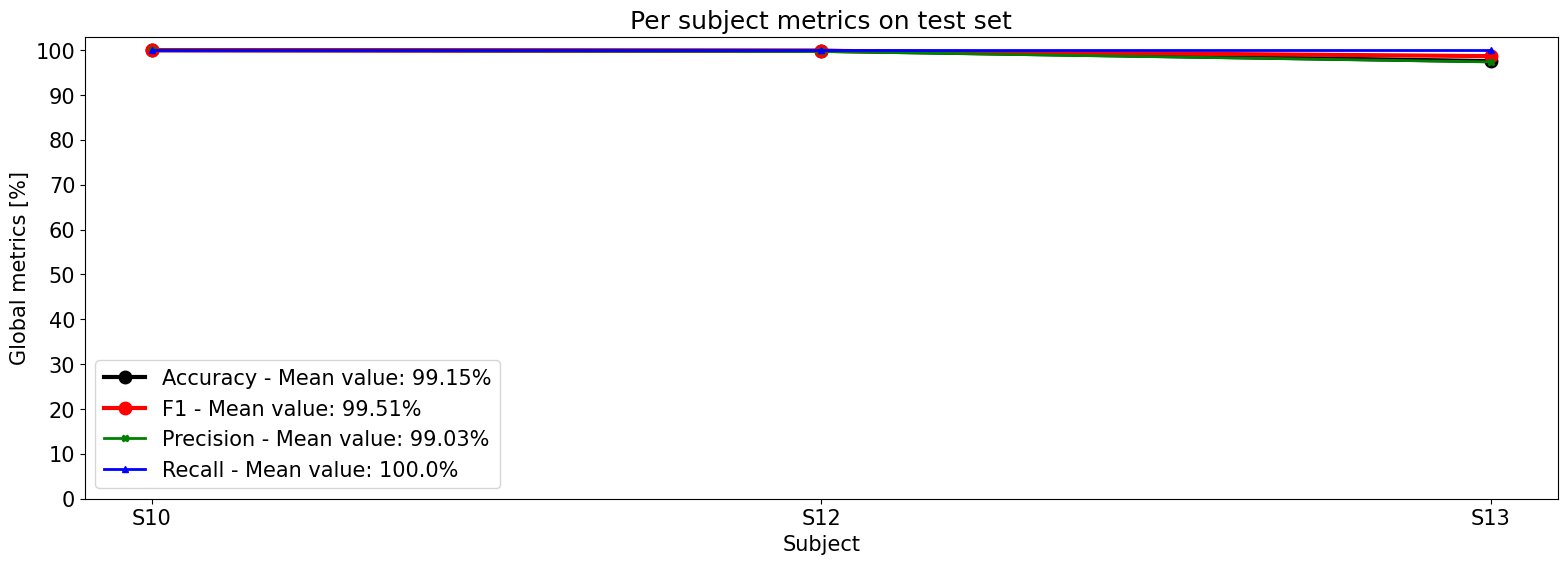

MEAN Accuracy: 99.15%
MEAN F1: 99.51%
MEAN Precision: 99.03%
MEAN Recall: 100.0%


In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Precompute the metrics and subjects list
metrics = {
    "Accuracy": [],
    "F1": [],
    "Precision": [],
    "Recall": []
}

for subj, values in prediction_results.items():
    y_true, y_pred = values['labels'], values['predictions']
    metrics["Accuracy"].append(accuracy_score(y_true, y_pred))
    metrics["F1"].append(f1_score(y_true, y_pred))
    metrics["Precision"].append(precision_score(y_true, y_pred))
    metrics["Recall"].append(recall_score(y_true, y_pred))

# Convert the lists to NumPy arrays and scale by 100
metrics = {key: np.array(value) * 100 for key, value in metrics.items()}

# Plotting
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(19,6))
subjs = np.arange(1, len(prediction_results) + 1)

mean_metrics = {key: np.nanmean(value).round(2) for key, value in metrics.items()}

# Iterate through metrics to plot them
markers = iter(['o', 'o', 'X', '^'])
colors = iter(['black', 'r', 'g', 'b'])
for metric, marker, color in zip(metrics.keys(), markers, colors):
    plt.plot(subjs, metrics[metric], '-', marker=marker, linewidth=3 if marker == 'o' else 2,
             markersize=9 if marker == 'o' else 5, color=color, markerfacecolor=color,
             label=f'{metric} - Mean value: {mean_metrics[metric]}%')

plt.title('Per subject metrics on test set')
plt.xlabel('Subject')
plt.ylabel('Global metrics [%]')
plt.xticks(subjs, labels=list(prediction_results.keys()))
plt.legend(loc='lower left')

axes = plt.gca()
axes.set_ylim([30, 103])
axes.yaxis.set_ticks(np.arange(0, 110, 10))
axes.set_xticklabels(list(prediction_results.keys()))
plt.show()

# Print the mean metrics
for metric, mean_value in mean_metrics.items():
    print(f'MEAN {metric}: {mean_value}%')

#### Confusion Matrix (CM) and Normalized CM (per subjects) computation


CM_total_normalized %:
 [[42.636   0.8542]
 [ 0.     56.5098]]
Sum: 100.0 %

Accuracy= 99.0 %
F1score= 99.5 %
Precision= 99.0 %
Recall= 100.0 %


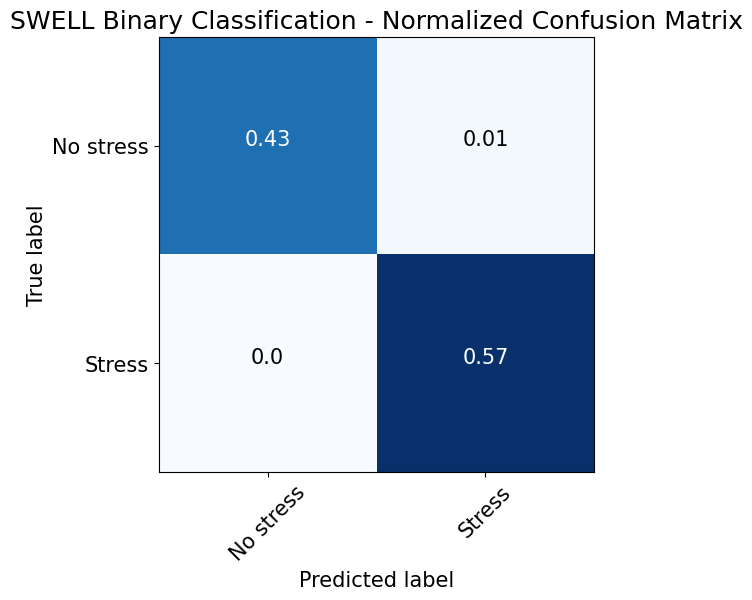

In [37]:
# Function to correct the confusion matrix dimensions
def correct_cm_dims(cm):
    if cm.size == 1:
        return np.array([[cm[0, 0], 0], [0, 0]])
    elif cm.size == 4:
        return cm
    else:
        print(f'Error in metrics shape for subject {subj}')
        return cm  # Or handle the error appropriately

# Get and correct all confusion matrices
CM_subjs = [correct_cm_dims(prediction_results[subj]['CM'].numpy()) for subj in prediction_results]

# Normalize and accumulate confusion matrices
CM_total_normalized = np.sum([cm / np.sum(cm) for cm in CM_subjs], axis=0) / len(CM_subjs)
CM_total_normalized = np.round(CM_total_normalized * 100, 4)

print('CM_total_normalized %:\n', CM_total_normalized)
print('Sum:', np.sum(CM_total_normalized), '%')

# Calculate metrics
tn, fp, fn, tp = CM_total_normalized.reshape(-1)  # Assumes a flattened order of [[0, 1], [2, 3]]
acc = np.round((tp + tn) / (tp + tn + fn + fp), 2) * 100
precision = np.round(tp / (tp + fp), 2) * 100
recall = np.round(tp / (tp + fn), 2) * 100
f1 = np.round(2 * (precision * recall) / (precision + recall), 2)

print('\nAccuracy=', acc, '%')
print('F1score=', f1, '%')
print('Precision=', precision, '%')
print('Recall=', recall, '%')

# Plot normalized confusion matrix
CM_plot = np.round(CM_total_normalized / 100, 2)
cmap = plt.get_cmap('Blues')

plt.figure(figsize=(8, 6))
plt.imshow(CM_plot, interpolation='nearest', cmap=cmap)
plt.title("SWELL Binary Classification - Normalized Confusion Matrix")

target_names = ['No stress', 'Stress']
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

thresh = CM_plot.max() / 1.5
for i, j in itertools.product(range(CM_plot.shape[0]), range(CM_plot.shape[1])):
    plt.text(j, i, "{:,}".format(CM_plot[i, j]), horizontalalignment="center",
             color="white" if CM_plot[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [39]:
import pandas as pd

# Extracting data from prediction_results
data = {
    'Subject': list(prediction_results.keys()),
    'TR-win': [prediction_results[s]['num_windows']['train'] for s in prediction_results],
    'VAL-win': [prediction_results[s]['num_windows']['val'] for s in prediction_results],
    'TEST-win': [prediction_results[s]['num_windows']['test'] for s in prediction_results]
}

# Creating DataFrame
info_win = pd.DataFrame(data)

# Calculating Total windows
info_win['Total windows'] = info_win['TR-win'] + info_win['VAL-win'] + info_win['TEST-win']

# Displaying DataFrame
display(info_win)

,Subject,TR-win,VAL-win,TEST-win,Total windows
0,S10,1607,230,459,2296
1,S12,2830,405,809,4044
2,S13,1864,267,533,2664


from matplotlib import pyplot as plt
info_win['TR-win'].plot(kind='hist', bins=20, title='TR-win')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
info_win['VAL-win'].plot(kind='hist', bins=20, title='VAL-win')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
info_win['TEST-win'].plot(kind='hist', bins=20, title='TEST-win')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
info_win['Total windows'].plot(kind='hist', bins=20, title='Total windows')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
info_win.groupby('Subject').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
info_win.plot(kind='scatter', x='TR-win', y='VAL-win', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
info_win.plot(kind='scatter', x='VAL-win', y='TEST-win', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
info_win.plot(kind='scatter', x='TEST-win', y='Total windows', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
info_win['TR-win'].plot(kind='line', figsize=(8, 4), title='TR-win')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
info_win['VAL-win'].plot(kind='line', figsize=(8, 4), title='VAL-win')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
info_win['TEST-win'].plot(kind='line', figsize=(8, 4), title='TEST-win')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
info_win['Total windows'].plot(kind='line', figsize=(8, 4), title='Total windows')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(info_win['Subject'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(info_win, x='TR-win', y='Subject', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(info_win['Subject'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(info_win, x='VAL-win', y='Subject', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(info_win['Subject'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(info_win, x='TEST-win', y='Subject', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(info_win['Subject'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(info_win, x='Total windows', y='Subject', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)